In [4]:
# EDA Notebook for PM2.5 Forecasting (Patna & Gurgaon)
# ----------------------------------------------------
# This notebook explores the datasets before forecasting.
# You'll get insights into PM2.5 behaviour, meteorological correlations,
# temporal patterns, and data quality issues.
#
# Author: Harshit
# Date: Oct 2025
# ----------------------------------------------------

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [11]:
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('coolwarm')

In [12]:
patna_path = '../data/df_patna_covariates.csv'
ggn_path = '../data/df_ggn_covariates.csv'

In [ ]:
df_patna    = pd.read_csv(patna_path)
df_ggn      = pd.read_csv(ggn_path)

# Convert timestamp column (col 1) to datetime
df_patna.iloc[:,0] = pd.to_datetime(df_patna.iloc[:,0], errors='coerce')
df_ggn.iloc[:,0] = pd.to_datetime(df_ggn.iloc[:,0], errors='coerce')

# Rename columns for clarity
columns = ['timestamp', 'humidity', 'temperature', 'wind_speed', 'pm25']
df_patna.columns    = columns
df_ggn.columns      = columns

# Set timestamp as index for convenience
df_patna.set_index('timestamp', inplace=True)
df_ggn.set_index('timestamp', inplace=True)

print('Patna shape:', df_patna.shape)
print('Gurgaon shape:', df_ggn.shape)

Patna shape: (4416, 4)
Gurgaon shape: (4416, 4)


/home/shubh/miniconda3/envs/chronos/lib/python3.11/site-packages/pandas/core/indexes/base.py:7654: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


In [ ]:
df_patna.head()
# df_ggn.tail()

,humidity,temperature,wind_speed,pm25
timestamp,,,,
2024-07-01 00:00:00,95.603333,26.713333,0.408333,30.061538
2024-07-01 01:00:00,95.720000,26.591667,0.395000,27.784906
2024-07-01 02:00:00,95.990000,26.476667,0.398333,28.754808
2024-07-01 03:00:00,96.360000,26.408333,0.380000,31.228846
2024-07-01 04:00:00,96.428333,26.375000,0.366667,36.105769


In [19]:
def summarize(df, name):
    print(f"===== {name.upper()} =====")
    print(df.info())
    print('\nMissing values per column:')
    print(df.isna().sum())
    print('\nDescriptive Statistics:')
    print(df.describe().T)
    print('\nSampling interval check:')
    diffs = df.index.to_series().diff().dropna().dt.total_seconds() / 3600
    print('Mean interval (hours):', diffs.mean())
    print('Std interval (hours):', diffs.std())
    print('\n')

summarize(df_patna, 'Patna')
summarize(df_ggn, 'Gurgaon')

===== PATNA =====
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2024-07-01 00:00:00 to 2024-12-31 23:00:00
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   humidity     4416 non-null   float64
 1   temperature  4416 non-null   float64
 2   wind_speed   4416 non-null   float64
 3   pm25         4416 non-null   float64
dtypes: float64(4)
memory usage: 172.5 KB
None

Missing values per column:
humidity       0
temperature    0
wind_speed     0
pm25           0
dtype: int64

Descriptive Statistics:
              count        mean         std        min        25%        50%  \
humidity     4416.0   79.045035   14.376171  31.530000  68.950179  82.009167   
temperature  4416.0   25.798862    4.773464  10.686667  23.518003  26.750000   
wind_speed   4416.0    0.612771    0.343436   0.266667   0.380000   0.473333   
pm25         4416.0  167.694815  152.101944   2.621372  45.384691  95.292859   

      

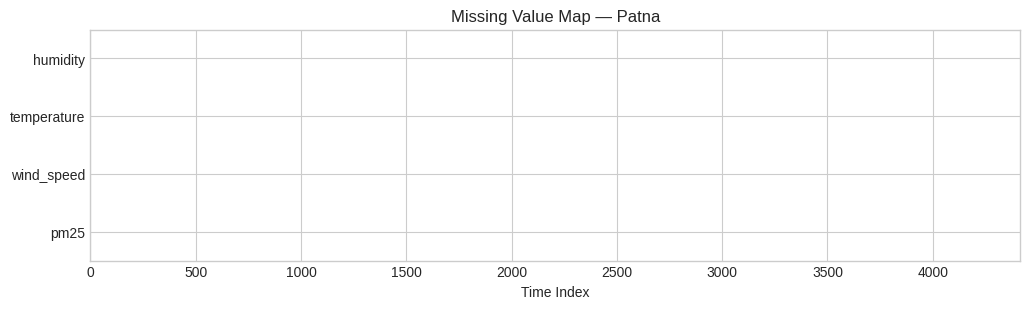

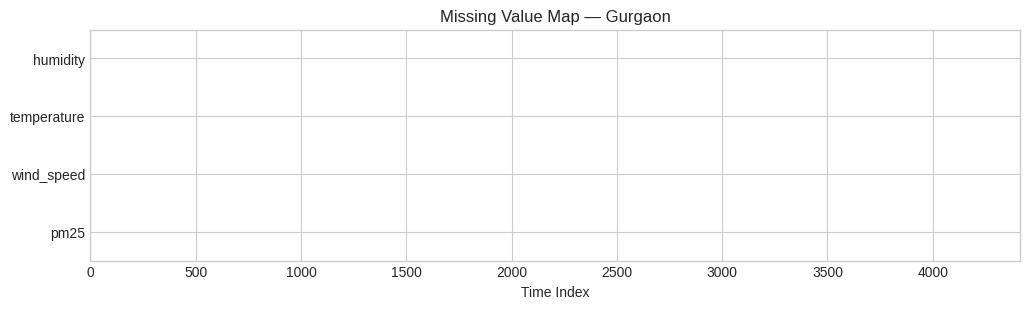

In [20]:
def plot_missing(df, city):
    plt.figure(figsize=(12,3))
    plt.imshow(df.isna().T, aspect='auto', cmap='gray_r', interpolation='none')
    plt.title(f'Missing Value Map — {city}')
    plt.yticks(range(len(df.columns)), df.columns)
    plt.xlabel('Time Index')
    plt.show()

plot_missing(df_patna, 'Patna')
plot_missing(df_ggn, 'Gurgaon')

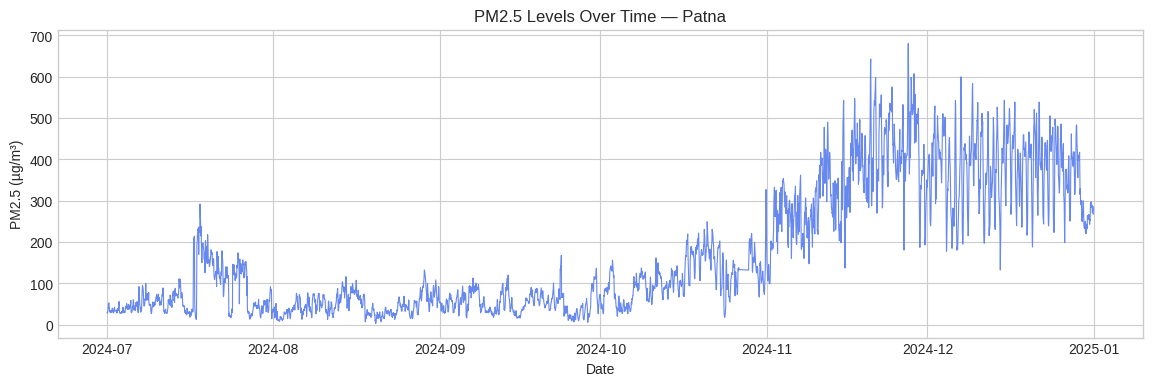

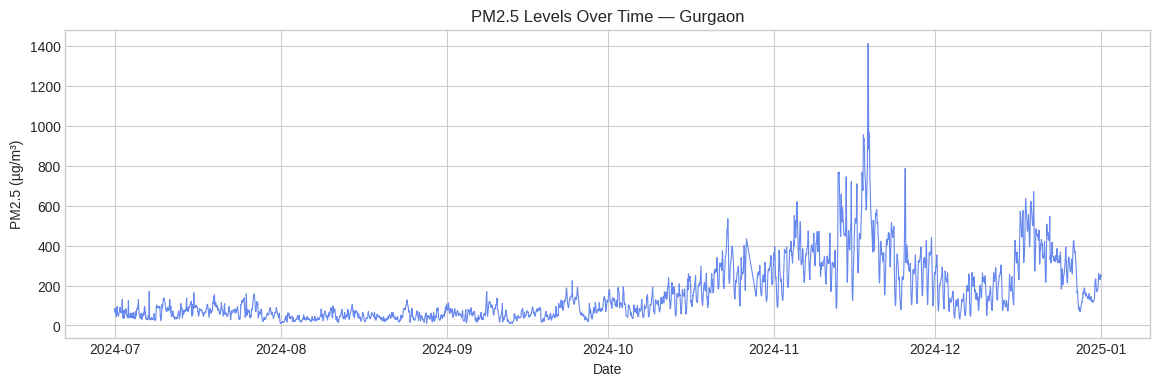

In [21]:
def plot_pm25(df, city):
    plt.figure(figsize=(14,4))
    plt.plot(df.index, df['pm25'], linewidth=0.8)
    plt.title(f'PM2.5 Levels Over Time — {city}')
    plt.xlabel('Date')
    plt.ylabel('PM2.5 (µg/m³)')
    plt.show()

plot_pm25(df_patna, 'Patna')
plot_pm25(df_ggn, 'Gurgaon')

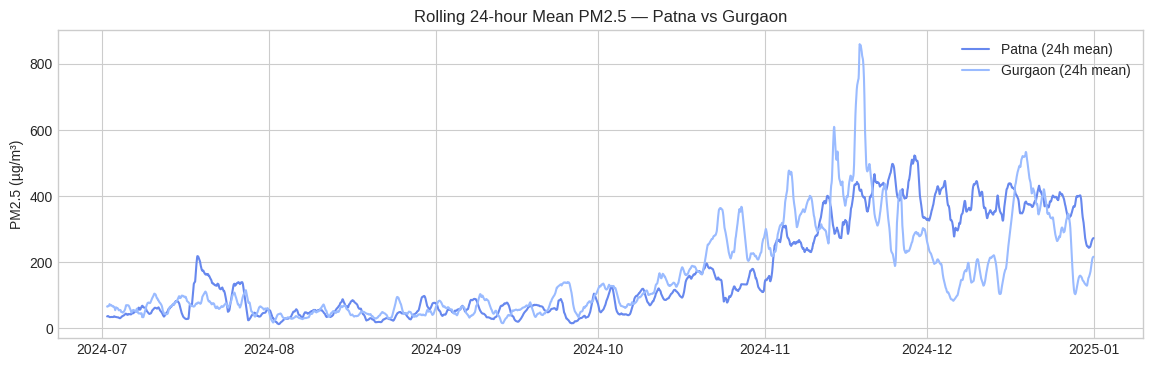

In [ ]:
window = 24
plt.figure(figsize=(14,4))
plt.plot(df_patna.index, df_patna['pm25'].rolling(window).mean(), label='Patna (24h mean)')
plt.plot(df_ggn.index, df_ggn['pm25'].rolling(window).mean(), label='Gurgaon (24h mean)')
plt.title('Rolling 24-hour Mean PM2.5 — Patna vs Gurgaon')
plt.ylabel('PM2.5 (µg/m³)')
plt.legend()
plt.show()

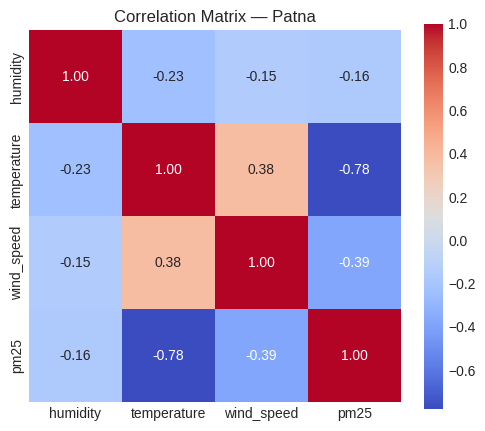

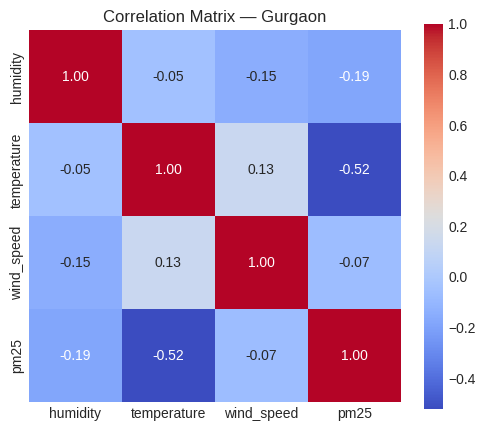

In [ ]:
def plot_corr(df, city):
    corr = df.corr()
    plt.figure(figsize=(6,5))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', square=True)
    plt.title(f'Correlation Matrix — {city}')
    plt.show()

plot_corr(df_patna, 'Patna')
plot_corr(df_ggn, 'Gurgaon')

# r ≈ 1.0 → strong positive relationship (when one increases, so does the other)
# r ≈ -1.0 → strong negative relationship (when one increases, the other decreases)
# r ≈ 0 → weak or no linear relationship

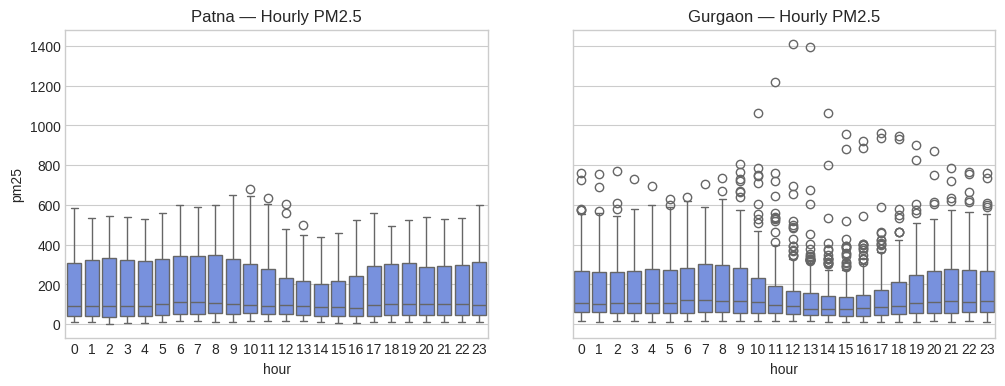

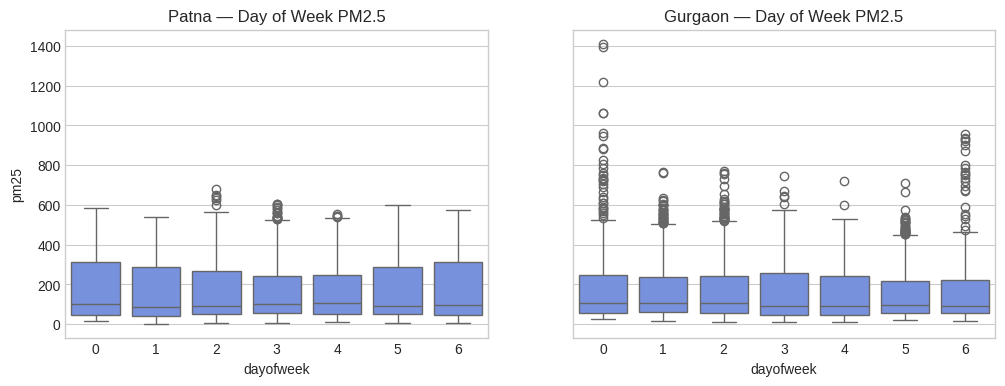

In [25]:
# %%
def add_time_features(df):
    df = df.copy()
    df['hour']      = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['month']     = df.index.month
    return df

df_patna_tf = add_time_features(df_patna)
df_ggn_tf   = add_time_features(df_ggn)

fig, ax = plt.subplots(1,2, figsize=(12,4), sharey=True)
sns.boxplot(data=df_patna_tf, x='hour', y='pm25', ax=ax[0])
ax[0].set_title('Patna — Hourly PM2.5')
sns.boxplot(data=df_ggn_tf, x='hour', y='pm25', ax=ax[1])
ax[1].set_title('Gurgaon — Hourly PM2.5')
plt.show()

fig, ax = plt.subplots(1,2, figsize=(12,4), sharey=True)
sns.boxplot(data=df_patna_tf, x='dayofweek', y='pm25', ax=ax[0])
ax[0].set_title('Patna — Day of Week PM2.5')
sns.boxplot(data=df_ggn_tf, x='dayofweek', y='pm25', ax=ax[1])
ax[1].set_title('Gurgaon — Day of Week PM2.5')
plt.show()

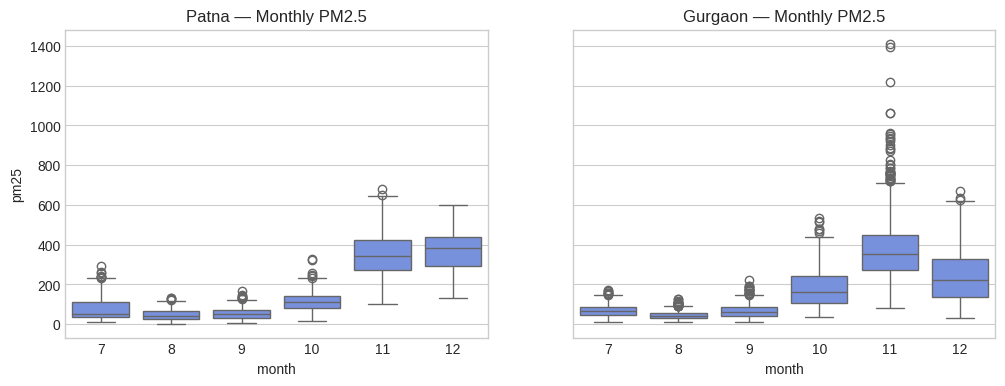

In [26]:
# %% [markdown]
# ## 9. Monthly Distributions
# Useful to identify seasonality (e.g., winter spikes due to inversions, crop burning).

# %%
fig, ax = plt.subplots(1,2, figsize=(12,4), sharey=True)
sns.boxplot(data=df_patna_tf, x='month', y='pm25', ax=ax[0])
ax[0].set_title('Patna — Monthly PM2.5')
sns.boxplot(data=df_ggn_tf, x='month', y='pm25', ax=ax[1])
ax[1].set_title('Gurgaon — Monthly PM2.5')
plt.show()

Patna: 5 outliers found (0.11% of data)


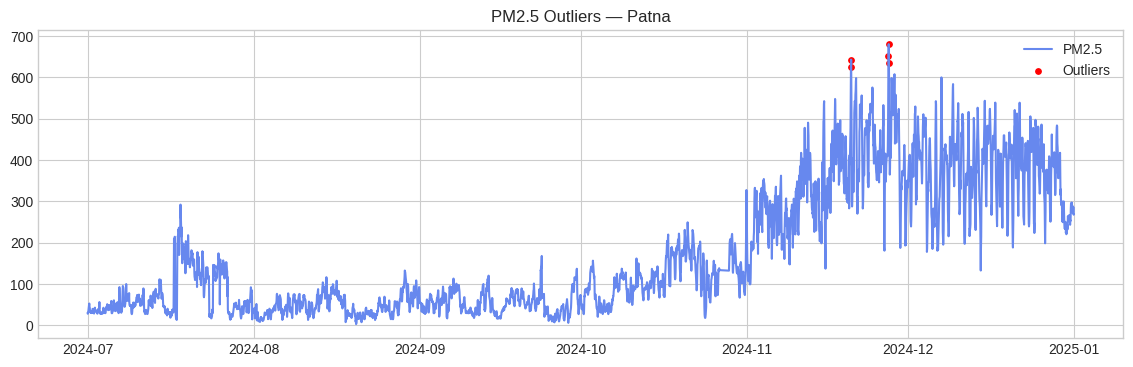

Gurgaon: 56 outliers found (1.27% of data)


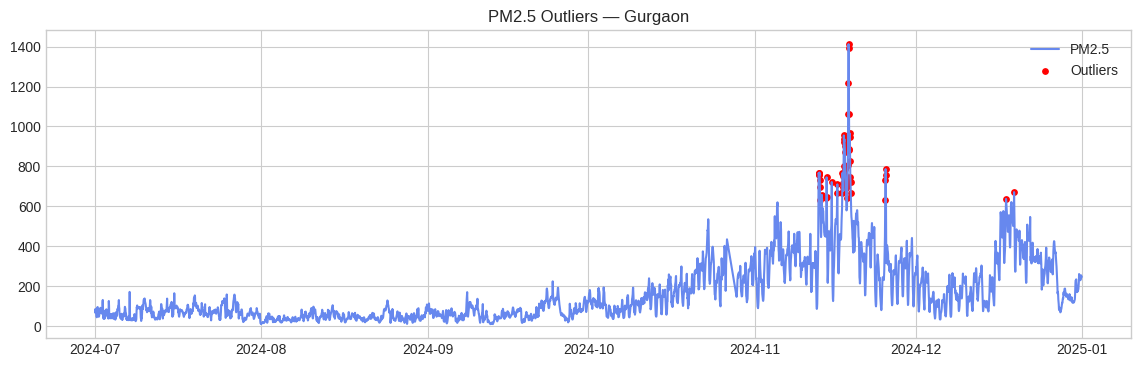

In [27]:
# %% [markdown]
# ## 10. Outlier Analysis
# We'll identify high PM spikes using z-scores (|z| > 3 considered outliers).

# %%
def detect_outliers(df, city):
    z = np.abs(stats.zscore(df['pm25'].dropna()))
    outlier_idx = np.where(z > 3)[0]
    print(f'{city}: {len(outlier_idx)} outliers found ({len(outlier_idx)/len(df)*100:.2f}% of data)')
    plt.figure(figsize=(14,4))
    plt.plot(df.index, df['pm25'], label='PM2.5')
    plt.scatter(df.index[outlier_idx], df['pm25'].iloc[outlier_idx], color='red', s=15, label='Outliers')
    plt.title(f'PM2.5 Outliers — {city}')
    plt.legend()
    plt.show()

detect_outliers(df_patna, 'Patna')
detect_outliers(df_ggn, 'Gurgaon')

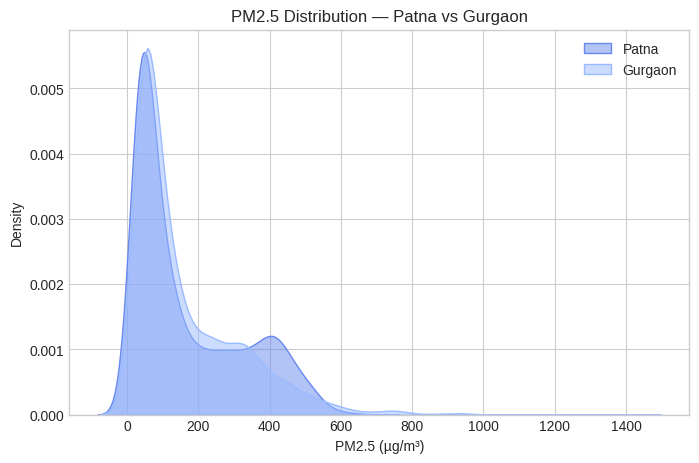

In [28]:
# %% [markdown]
# ## 11. Comparative Distribution (Patna vs Gurgaon)
# Let's overlay histograms and KDE plots to see which city has higher PM averages.

# %%
plt.figure(figsize=(8,5))
sns.kdeplot(df_patna['pm25'], label='Patna', fill=True, alpha=0.5)
sns.kdeplot(df_ggn['pm25'], label='Gurgaon', fill=True, alpha=0.5)
plt.title('PM2.5 Distribution — Patna vs Gurgaon')
plt.xlabel('PM2.5 (µg/m³)')
plt.legend()
plt.show()

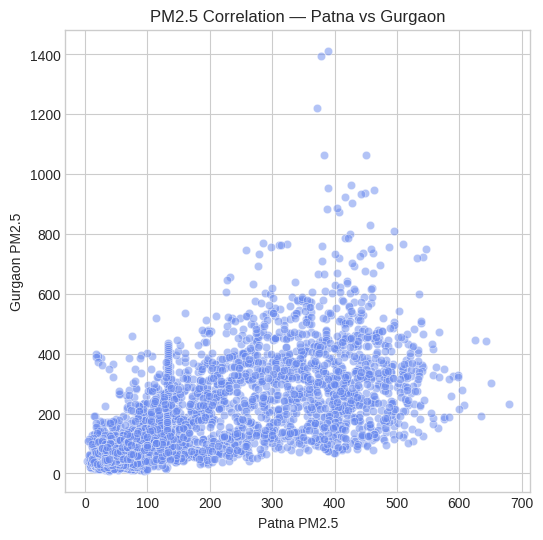

Inter-city PM2.5 correlation: 0.69


In [29]:
# %% [markdown]
# ## 12. Correlation Between Cities
# To check if both cities show synchronous pollution trends (e.g., due to regional weather).

# %%
df_common = pd.merge(df_patna[['pm25']], df_ggn[['pm25']], left_index=True, right_index=True, suffixes=('_patna','_ggn'))
plt.figure(figsize=(6,6))
sns.scatterplot(data=df_common, x='pm25_patna', y='pm25_ggn', alpha=0.5)
plt.title('PM2.5 Correlation — Patna vs Gurgaon')
plt.xlabel('Patna PM2.5')
plt.ylabel('Gurgaon PM2.5')
plt.show()

corr_val = df_common.corr().iloc[0,1]
print(f'Inter-city PM2.5 correlation: {corr_val:.2f}')

# %% [markdown]
# ## 13. Key Takeaways Section (Fill after exploration)
# After you’ve seen the plots, summarize:
# - Are there strong daily or seasonal patterns?
# - Which meteorological factor correlates most with PM2.5?
# - Are there missing chunks or irregular timestamps?
# - Which city exhibits higher overall pollution and variance?
# - How might context length (days) affect prediction stability?
#
# Once these observations are recorded, you’ll be ready for **Part 1 Chronos experiments**.
#
# ---
